In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings("ignore")

# I. Preprocess Data

In [26]:
df = pd.read_csv('Lake_Bilancino.csv')
df

,Date,Rainfall_S_Piero,Rainfall_Mangona,Rainfall_S_Agata,Rainfall_Cavallina,Rainfall_Le_Croci,Temperature_Le_Croci,Lake_Level,Flow_Rate
0,03/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31
1,04/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31
2,05/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31
3,06/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31
4,07/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.44,0.31
...,...,...,...,...,...,...,...,...,...
6598,26/06/2020,0.0,0.0,0.0,0.0,0.0,22.50,250.85,0.60
6599,27/06/2020,0.0,0.0,0.0,0.0,0.0,23.40,250.84,0.60
6600,28/06/2020,0.0,0.0,0.0,0.0,0.0,21.50,250.83,0.60
6601,29/06/2020,0.0,0.0,0.0,0.0,0.0,23.20,250.82,0.60


In [27]:
print(f"Num rows: {df.shape[0]}")
print(f"Num cols: {df.shape[1]}")
print(f"Columns: {df.columns.tolist()}")
print(f"Data types:\n{df.dtypes}")
print(f"Missing values:\n{df.isnull().sum()}")
print(f"Unique values:\n{df.nunique()}")

Num rows: 6603
Num cols: 9
Columns: ['Date', 'Rainfall_S_Piero', 'Rainfall_Mangona', 'Rainfall_S_Agata', 'Rainfall_Cavallina', 'Rainfall_Le_Croci', 'Temperature_Le_Croci', 'Lake_Level', 'Flow_Rate']
Data types:
Date                     object
Rainfall_S_Piero        float64
Rainfall_Mangona        float64
Rainfall_S_Agata        float64
Rainfall_Cavallina      float64
Rainfall_Le_Croci       float64
Temperature_Le_Croci    float64
Lake_Level              float64
Flow_Rate               float64
dtype: object
Missing values:
Date                      0
Rainfall_S_Piero        577
Rainfall_Mangona        577
Rainfall_S_Agata        577
Rainfall_Cavallina      577
Rainfall_Le_Croci       577
Temperature_Le_Croci    578
Lake_Level                0
Flow_Rate                21
dtype: int64
Unique values:
Date                    6603
Rainfall_S_Piero         206
Rainfall_Mangona         247
Rainfall_S_Agata         207
Rainfall_Cavallina       219
Rainfall_Le_Croci        230
Temperature_Le_Cr

In [28]:
# Take only Date and Lake_Level columns
df = df[['Date', 'Lake_Level']]
df.columns = ['date', 'lake_level']
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.dayofyear

start_year = 2016
end_year = 2019

df = df[(df['year'] >= start_year) & (df['year'] <= end_year)]
df

,date,lake_level,year,month,day
4960,2016-01-01,246.91,2016,1,1
4961,2016-01-02,247.14,2016,1,2
4962,2016-01-03,247.18,2016,1,3
4963,2016-01-04,247.20,2016,1,4
4964,2016-01-05,247.22,2016,1,5
...,...,...,...,...,...
6416,2019-12-27,250.32,2019,12,361
6417,2019-12-28,250.21,2019,12,362
6418,2019-12-29,250.13,2019,12,363
6419,2019-12-30,250.04,2019,12,364


# II. Investigate trends

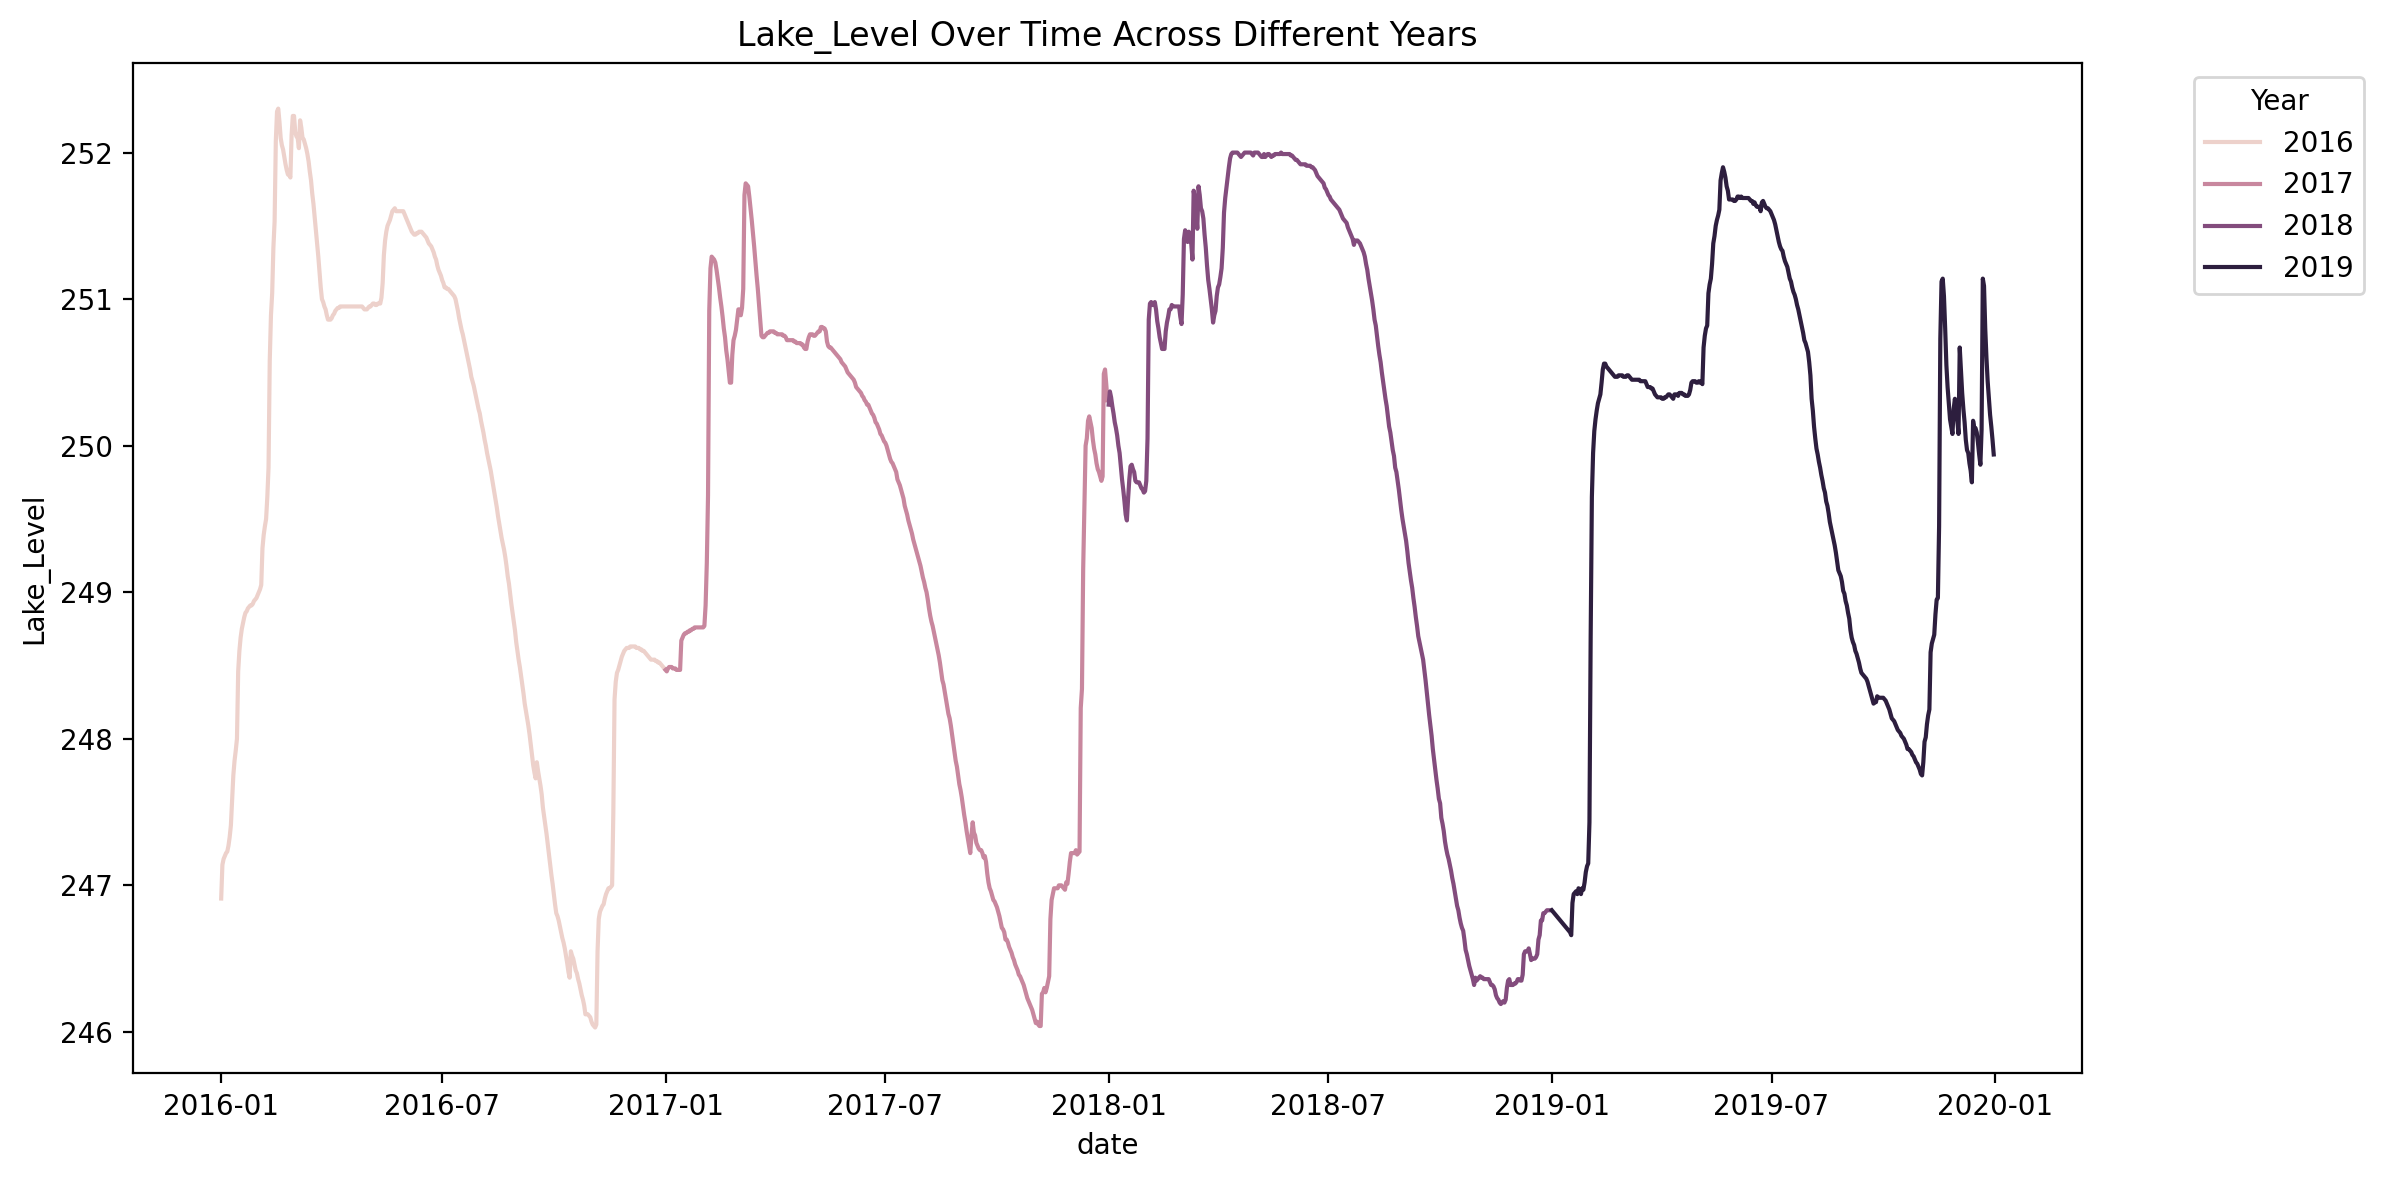

In [29]:
plt.figure(figsize=(12, 6), dpi=200)
sns.lineplot(data=df, x='date', y='lake_level', hue='year')
plt.xlabel('date')
plt.ylabel('Lake_Level')
plt.title('Lake_Level Over Time Across Different Years')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

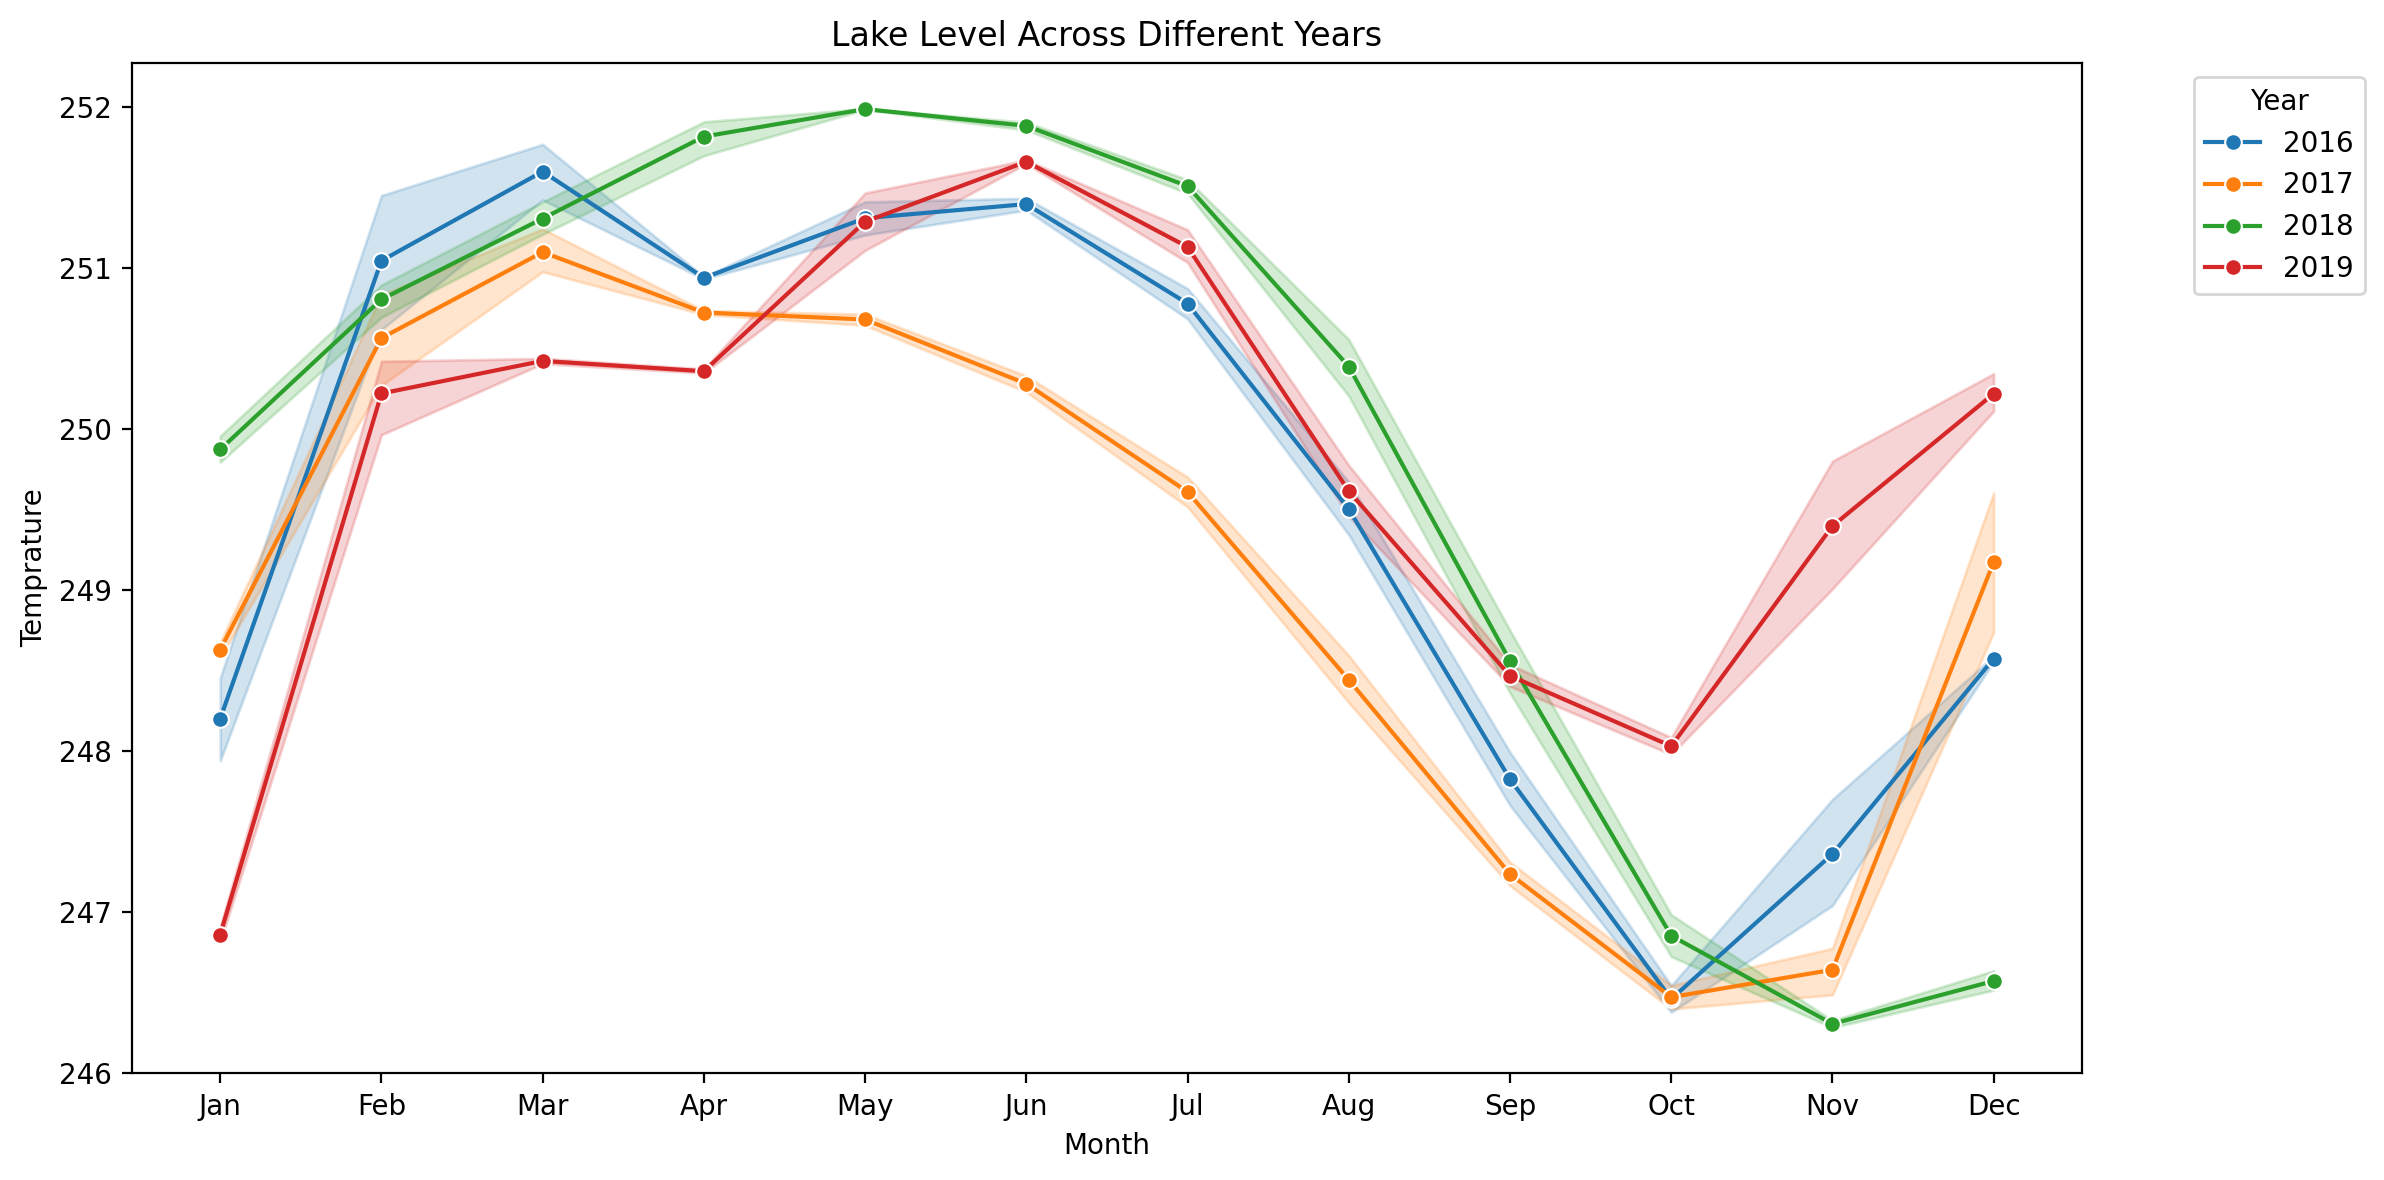

In [30]:
plt.figure(figsize=(12, 6), dpi=200)
sns.lineplot(data=df, x='month', y='lake_level',
             hue='year', marker='o', palette='tab10')
plt.xlabel('Month')
plt.ylabel('Temprature')
plt.title('Lake Level Across Different Years')
plt.xticks(ticks=range(1, 13), labels=[
           'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

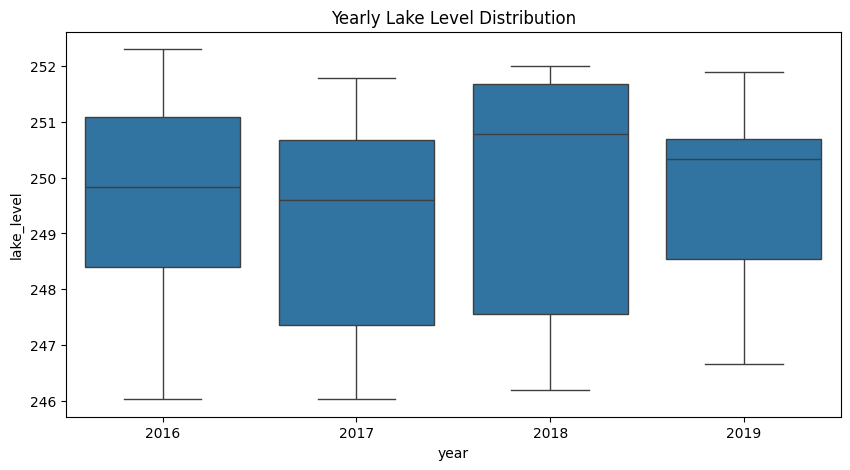

In [31]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='year', y='lake_level', data=df)
plt.title("Yearly Lake Level Distribution")
plt.show()

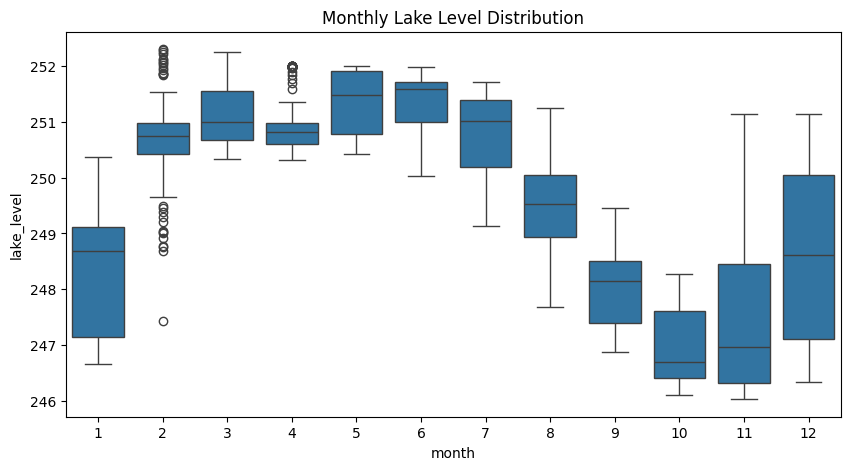

In [32]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='month', y='lake_level', data=df)
plt.title("Monthly Lake Level Distribution")
plt.show()

# III. Time Series Analysis

## 1. Scaling, (1 điểm)


In [33]:
import pandas as pd


def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [34]:
import numpy as np


class DifferenceScaler:
    def __init__(self, d=1):
        """
        Initialize the Differencing Scaler with order d.

        Parameters:
        d (int): The order of differencing.
        """
        self.d = d
        self.initial_values = None

    def fit(self, X):
        """
        Store the initial values required for inverse transformation.

        Parameters:
        X (array-like): The input data to fit.
        """
        X = np.array(X)
        self.initial_values = [X[:self.d]]
        for i in range(1, self.d):
            self.initial_values.append(np.diff(X[:self.d + i]))
        return self

    def transform(self, X):
        """
        Perform differencing on the data.

        Parameters:
        X (array-like): The input data to transform.

        Returns:
        np.array: The differenced data.
        """
        X = np.array(X)
        differenced = X
        for _ in range(self.d):
            differenced = np.diff(differenced)
        return differenced

    def inverse_transform(self, X):
        """
        Inverse transform the differenced data to the original data.

        Parameters:
        X (array-like): The differenced data to inverse transform.

        Returns:
        np.array: The original data.
        """
        X = np.array(X)
        for initial in reversed(self.initial_values):
            X = np.concatenate((initial, X)).cumsum()
        return X

In [35]:
dif_scaler = DifferenceScaler(d=1)
dataset = pd.DataFrame(dif_scaler.transform(df['lake_level'].values))
dataset

,0
0,0.23
1,0.04
2,0.02
3,0.02
4,0.01
...,...
1455,-0.12
1456,-0.11
1457,-0.08
1458,-0.09


In [36]:
data = series_to_supervised(dataset, n_in=3, n_out=1)
print(data)

      var1(t-3)  var1(t-2)  var1(t-1)  var1(t)
3          0.23       0.04       0.02     0.02
4          0.04       0.02       0.02     0.01
5          0.02       0.02       0.01     0.04
6          0.02       0.01       0.04     0.06
7          0.01       0.04       0.06     0.08
...         ...        ...        ...      ...
1455      -0.29      -0.20      -0.16    -0.12
1456      -0.20      -0.16      -0.12    -0.11
1457      -0.16      -0.12      -0.11    -0.08
1458      -0.12      -0.11      -0.08    -0.09
1459      -0.11      -0.08      -0.09    -0.10

[1457 rows x 4 columns]


In [37]:
X, y = data[['var1(t-3)', 'var1(t-2)', 'var1(t-1)']
            ].values, data['var1(t)'].values
print(X, y)

[[ 0.23  0.04  0.02]
 [ 0.04  0.02  0.02]
 [ 0.02  0.02  0.01]
 ...
 [-0.16 -0.12 -0.11]
 [-0.12 -0.11 -0.08]
 [-0.11 -0.08 -0.09]] [ 0.02  0.01  0.04 ... -0.08 -0.09 -0.1 ]


## 2. Building, (1 điểm)

In [38]:
# prompt: Chia X, y thành 80% train và 20% test. Sau đó scale dữ liệu cả X và y

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Chuẩn hóa dữ liệu
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

scaler_y = StandardScaler()
Y_train = scaler_y.fit_transform(Y_train.reshape(-1, 1)).ravel()
Y_test = scaler_y.transform(Y_test.reshape(-1, 1)).ravel()

### 2.1. AdaBoost Regressor

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.ensemble import AdaBoostRegressor

# Initialize the estimator
estimator = AdaBoostRegressor(n_estimators=500, learning_rate=0.05)

# Fit the data
estimator.fit(X_train, Y_train)

# Make predictions
pred = estimator.predict(X_test)

# Calculate metrics
print(mean_squared_error(Y_test, pred))
print(mean_absolute_percentage_error(Y_test, pred))
print(r2_score(Y_test, pred))

1.4777128229742775
3.269625381726285
0.010801069486419457


In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score


def draw_true_predict(y_true, y_pred):
    size = len(y_true)
    plt.plot(list(range(size)), y_true, label='real', color='blue')
    plt.plot(list(range(size)), y_pred, label='predicted', color='red')
    plt.legend(loc='best')
    plt.title('Real vs Predicted values')
    plt.show()


def calculate_metrics(y_true, y_pred):
    # Calculate metrics
    MSE = mean_squared_error(Y_test, pred)
    MAPE = mean_absolute_percentage_error(Y_test, pred)
    R2 = r2_score(Y_test, pred)
    print(f"MSE: {MSE}, MAPE: {MAPE}, R2: {R2}")

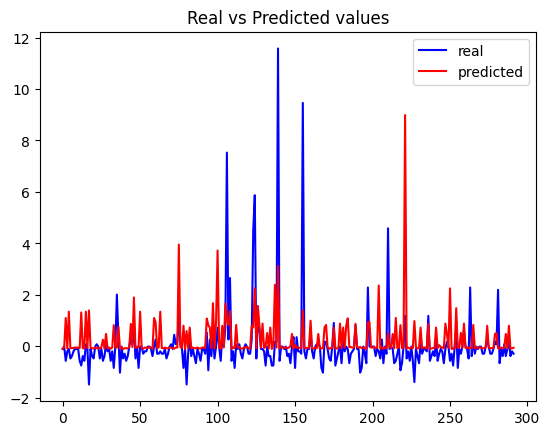

In [41]:
draw_true_predict(Y_test, pred)

### 2.2. RandomForest Regressor

MSE: 1.451861240071476, MAPE: 2.319485651337121, R2: 0.028106433398781827


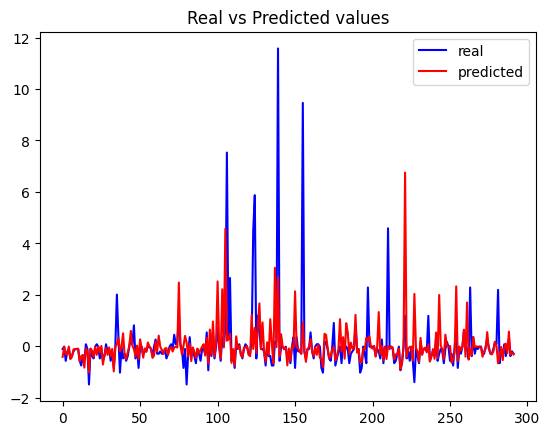

In [42]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the estimator
estimator = RandomForestRegressor()

# Fit the data
estimator.fit(X_train, Y_train)

# Make predictions
pred = estimator.predict(X_test)

# Calculate metrics
calculate_metrics(Y_test, pred)

draw_true_predict(Y_test, pred)

### 2.3. SVR

MSE: 1.3290463798111416, MAPE: 1.8421480025762937, R2: 0.11032019410512217


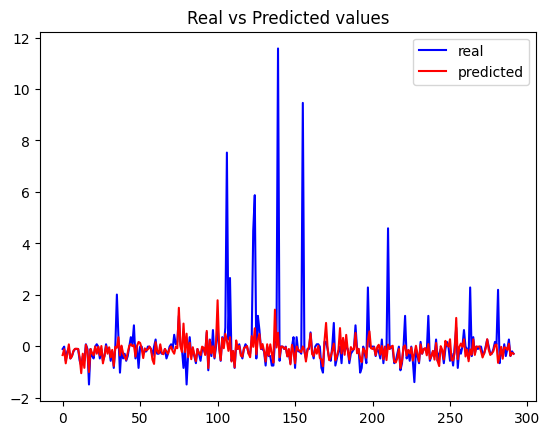

In [43]:
from sklearn.svm import SVR

# Initialize the estimator
estimator = rfr = SVR(C=10, epsilon=0.1)

# Fit the data
estimator.fit(X_train, Y_train)

# Make predictions
pred = estimator.predict(X_test)

# Calculate metrics
calculate_metrics(Y_test, pred)

draw_true_predict(Y_test, pred)

## 3. Hyper-parameter tuning, (2 điểm)
## 5. GridsearchCV, (1 điểm)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END ......C=1, epsilon=0.1, kernel=rbf;, score=0.172 total time=   0.0s
[CV 2/5] END ......C=1, epsilon=0.1, kernel=rbf;, score=0.151 total time=   0.0s
[CV 3/5] END ......C=1, epsilon=0.1, kernel=rbf;, score=0.202 total time=   0.0s
[CV 4/5] END ......C=1, epsilon=0.1, kernel=rbf;, score=0.155 total time=   0.0s
[CV 5/5] END ......C=1, epsilon=0.1, kernel=rbf;, score=0.421 total time=   0.0s
[CV 1/5] END ...C=1, epsilon=0.1, kernel=linear;, score=0.056 total time=   0.0s
[CV 2/5] END ...C=1, epsilon=0.1, kernel=linear;, score=0.193 total time=   0.0s
[CV 3/5] END ...C=1, epsilon=0.1, kernel=linear;, score=0.437 total time=   0.0s
[CV 4/5] END ...C=1, epsilon=0.1, kernel=linear;, score=0.241 total time=   0.0s
[CV 5/5] END ...C=1, epsilon=0.1, kernel=linear;, score=0.346 total time=   0.0s
[CV 1/5] END ........C=1, epsilon=0, kernel=rbf;, score=0.166 total time=   0.0s
[CV 2/5] END ........C=1, epsilon=0, kernel=rbf

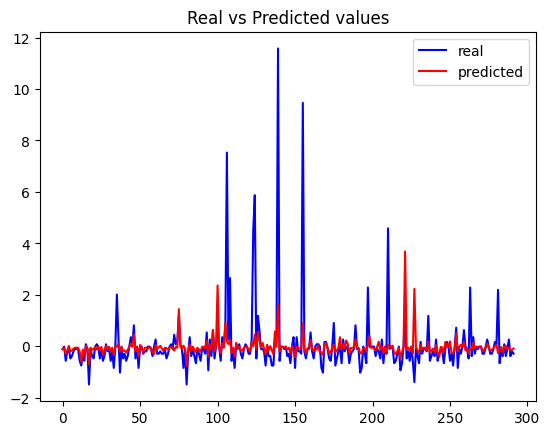

In [44]:
# Hyper-parameter tuning using GridSearchCV

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

# defining parameter range
param_grid = {
    'C': [1, 10, 100],
    'epsilon': [0.1, 0,2, 0.5],
    'kernel': ['rbf', 'linear']
}

# defining the gridsearchCV object
grid = GridSearchCV(SVR(), param_grid, refit=True, verbose=3)

# Fit the data
grid.fit(X_train, Y_train)

# Make predictions
pred = grid.predict(X_test)

# Calculate metrics
calculate_metrics(Y_test, pred)

draw_true_predict(Y_test, pred)

## 4. Pipeline, (1 điểm)
## 6. Forecasting, (1 điểm)
## 7. Calculate Metrics ví dụ như RMSE, MSE, MAE, MAPE (2 điểm)
## 8. Vẽ đồ thị giá trị thực tế và dự đoán (1 điểm)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END SVR__C=13.914379586623992, SVR__epsilon=0.6366842923640331, SVR__kernel=linear;, score=0.159 total time=   0.0s
[CV 2/3] END SVR__C=13.914379586623992, SVR__epsilon=0.6366842923640331, SVR__kernel=linear;, score=0.255 total time=   0.0s
[CV 3/3] END SVR__C=13.914379586623992, SVR__epsilon=0.6366842923640331, SVR__kernel=linear;, score=0.325 total time=   0.0s
[CV 1/3] END SVR__C=29.66264867649996, SVR__epsilon=0.7900922829436802, SVR__kernel=linear;, score=0.134 total time=   0.0s
[CV 2/3] END SVR__C=29.66264867649996, SVR__epsilon=0.7900922829436802, SVR__kernel=linear;, score=0.217 total time=   0.0s
[CV 3/3] END SVR__C=29.66264867649996, SVR__epsilon=0.7900922829436802, SVR__kernel=linear;, score=0.284 total time=   0.0s
[CV 1/3] END SVR__C=39.11196153947852, SVR__epsilon=0.5607200739582094, SVR__kernel=rbf;, score=0.123 total time=   0.0s
[CV 2/3] END SVR__C=39.11196153947852, SVR__epsilon=0.5607200739582094,

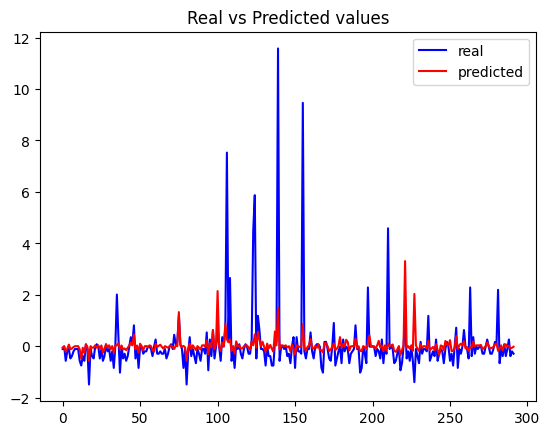

In [45]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform


# ++++++++++++++++++++++++++++++++
# create the pipeline object
# ++++++++++++++++++++++++++++++++
steps = [('scaler', StandardScaler()), ('SVR', SVR())]
pipeline = Pipeline(steps)


# ++++++++++++++++++++++++++++++++++++++
# + create the hyperparameter space
# ++++++++++++++++++++++++++++++++++++++
parameteres = {
    'SVR__C': uniform(1, 100),
    'SVR__epsilon': uniform(0.1, 1),
    'SVR__kernel': ['rbf', 'linear']
}

# ++++++++++++++++++++++++++++++
# + Grid Search Cross Validation
# ++++++++++++++++++++++++++++++
grid = RandomizedSearchCV(
    pipeline, param_distributions=parameteres, cv=3, verbose=3)

# Fit the data
grid.fit(X_train, Y_train)

# get the best parameters
print(grid.best_params_)

# Make predictions
pred = grid.predict(X_test)

# Calculate metrics
calculate_metrics(Y_test, pred)

draw_true_predict(Y_test, pred)